Implementing a basic DE solver for the neutrino winds in terms of psi

Runge-Kutta method from Wikipedia:
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/25f03454fd25957cc63be11ec534efdce349c52f">
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/95bdbb2e3aa83735085c0aadd577162c69e4056a">
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/81398071e8f180ac143bfdf4598ff47bf79eb689">
I use $\psi$ in place of t, and {r,v} as y. I calculate separate k values for r and v to get y'={r',v'}

Questions/next steps:

Use scipy integrator to find solutions?
Use absolute value of f1,f2 and minimize the distance between their zeros as a function of v0

In [4]:
import numpy as np
import matplotlib.pyplot as plt
np.seterr(all='raise')

cs=1
M=10
G=1
mB=1
dPdS=1
Se=0
rho=1
T=1
r0=1

def ndf1(psi,coords):
    '''Dimensionless f1 function, takes t,(x,y) and returns 1-exp[2y]'''
    try:
        return 1-np.exp(2*coords[1])
    except:
        print("Error in ndf1 at ",psi,", ",coords)
        return 0

def ndf2(psi,coords):
    '''Dimensionless f2 function, takes t,(x,y) and returns (GM/r0*cs^2)exp[-x]-2'''
    return np.exp(-coords[0])*G*M/((cs**2)*r0)-2

def CoupledRungeKuttaStep(af1,af2,fn,t,dt): 
    """Takes functions af1 and af2, state f(n), t and dt, and steps f(n) to f(n+dt) using an RK4 method with arbitrary input functions f1 and f2
    Returns t+dt,f(n+dt)"""  
    f1k1=dt*af1(t,fn)
    f2k1=dt*af2(t,fn)
    f1k2=dt*af1(t+dt/2,fn+np.array([f1k1/2,f2k1/2]))
    f2k2=dt*af2(t+dt/2,fn+np.array([f1k1/2,f2k1/2]))
    f1k3=dt*af1(t+dt/2,fn+np.array([f1k2/2,f2k2/2]))
    f2k3=dt*af2(t+dt/2,fn+np.array([f1k2/2,f2k2/2]))
    f1k4=dt*af1(t+dt,fn+np.array([f1k3,f2k3]))
    f2k4=dt*af2(t+dt,fn+np.array([f1k3,f2k3]))
    return np.array([t+dt,np.array([fn[0]+(f1k1+2*f1k2+2*f1k3+f1k4)/6,fn[1]+(f2k1+2*f2k2+2*f2k3+f2k4)/6])])

def percentChange(curr,step):
    '''Takes a current state and a new state (vectors) and calculates the percent change'''
    return 100*abs(np.linalg.norm((step-curr)/np.linalg.norm(curr)))

def generateFunc(x0,u0,itermax):
    """Generates a trace of wind behavior with initial conditions x0 and u0 (dimensionless) using the RK4 method with adaptation in dt
    Takes x0, u0, max iteration count and returns a 2D array tracking t, x, and u"""
    xsol=np.array([x0])
    usol=np.array([u0])
    tarray=np.array([0])
    t=0
    dt=.01
    ddt=1.5
    i=0
    prevstate=0
    currState=np.array([xsol[-1],usol[-1]])
    
    #Main loop for adaptive RK solver
    #Exit conditions are based on values for exp(x)
    #Using zero points for f1 and f2 only works if you change ndf1 and ndf2 to return absolute values, and then you don't see the full curve
    #Setting a max iteration count doesn't always work well - the solution curves may be cut
    while np.exp(currState[0])>1e-6 and np.exp(currState[0])<5: #and abs(ndf1(t,currState))>.001 and ndf2(t,currState)>.001:
        
        #Load the current position of the system to determine if adaptation is necessary
        currState=np.array([xsol[-1],usol[-1]])
        
        #Calculate the next integration step using the RK function defined above
        step=CoupledRungeKuttaStep(ndf1,ndf2,currState,t,dt)
        
        #Calculate percent change from current state to predicted next state
        try:
            pc=percentChange(currState,step[1])
        except:
            print("Error at %change, currState: ",currState," step: ",step)
            break
                
        #Adapt dt to ensure the change in (x,u) is between .1 and 1 percent
        #This system does not always behave as expected, so the adaptation iteratively finds a new dt to correct the error
        #This new dt can be either larger or smaller, independent of the initial percent change
        
        if pc>1:
            pc2=1e10 #initialize dummy percent changes, used to track movement in % change while finding new dt
            prevpc2=1e10
            while pc2>1:
                dt=dt*ddt
                step2=CoupledRungeKuttaStep(ndf1,ndf2,currState,t,dt) #calculate hypothetical next step using new dt
                pc2=percentChange(currState,step2[1])
                if pc2>prevpc2: #if we're moving in the wrong direction, invert our change in dt
                    ddt=1/ddt
                prevpc2=pc2
            step=step2 #once we've found a working dt, take a step using it
        elif pc<.1: 
            pc2=1e-10 #initialize dummy percent changes, used to track movement in % change while finding new dt
            prevpc2=1e-10
            while pc2<.1:
                dt=dt*ddt
                step2=CoupledRungeKuttaStep(ndf1,ndf2,currState,t,dt) #calculate hypothetical next step using new dt
                pc2=percentChange(currState,step2[1])
                if pc2<prevpc2: #if we're moving in the wrong direction, invert our change in dt
                    ddt=1/ddt
                prevpc2=pc2
            step=step2 #once we've found a working dt, take a step using it
               
        xsol=np.append(xsol,step[1][0]) #update solution curves with next step
        usol=np.append(usol,step[1][1])
        t=t+dt
        tarray=np.append(tarray,t)
    #print("*********Iteration complete***********, exit conditions t=",t,", exp(x)=",np.exp(currState[0]))
    return np.array((tarray,xsol,usol))

def makePlot(minX,maxX,dx):
    """Generates a plot of wind curves
    Takes minX, maxX, dx and generates a curve for x0 (u0=0), then increments x0 by dx and generates a new curve, repeating until x0=maxX
    Returns 0, prints a plot of the different wind curves"""
    plt.figure(1)
    plt.xlim(1,5)
    plt.ylim(0,5)

    for i in np.arange(minX,maxX,dx):
        #print("\n*******iteration********* ",i,"\n")
        func=generateFunc(0,np.log(i),50)
        plt.scatter(np.exp(func[1]),np.exp(func[2]),s=.5);
    return 0

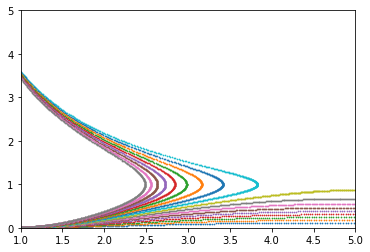

In [5]:
makePlot(.001,.01,.0005);

In [7]:
print(100*abs(np.linalg.norm((np.array([-0.46618877,1.57632707])-np.array([-0.45231597,1.56768413]))/np.linalg.norm(np.array([-0.45231597,1.56768413])))))

1.0017501338956245


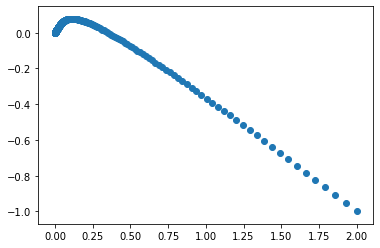

In [11]:
#Testing the CoupledRungeKuttaStep function with a known DE
#It works as expected

def testf(t,x):
    return -3*x[0]+np.sqrt(2)*x[1]
def testf2(t,x):
    return np.sqrt(2)*x[0]-2*x[1]

def generateTestFunc(x0,y0):
    x1=np.array([x0])
    x2=np.array([y0])
    t=0
    while t<10:
        step=CoupledRungeKuttaStep(testf,testf2,np.array([x1[-1],x2[-1]]),t,.01)
        x1=np.append(x1,step[1][0])
        x2=np.append(x2,step[1][1])
        t=t+.01
        #print(xstep)
    return np.array([x1,x2])

func2=generateTestFunc(2,-1)
plt.scatter(func2[0],func2[1])

In [48]:
import scipy.integrate as sc

def ndf1(psi,coords):
    return 1-np.exp(2*coords[1])

def ndf2(psi,coords):
    return np.exp(-coords[0])*G*M/((cs**2)*r0)-2

lambda t,y: (ndf1(t,y),ndf2(t,y))

sol=sc.solve_ivp(lambda t,y: (ndf1(t,y),ndf2(t,y)),(0,np.log(5)),(0,np.log(.001)))

In [49]:
sol['t']

array([0.00000000e+00, 9.99855586e-04, 1.09984114e-02, 1.10983970e-01,
       1.11083956e+00, 1.60943791e+00])

In [50]:
sol['y']

array([[ 0.00000000e+00,  9.99854578e-04,  1.09983994e-02,
         1.10983680e-01,  1.10891765e+00,  1.60151079e+00],
       [-6.90775528e+00, -6.89976143e+00, -6.82037060e+00,
        -6.07925406e+00, -2.42083165e+00, -2.11951257e+00]])

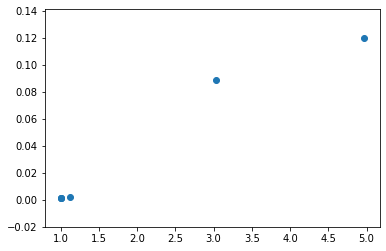

In [51]:
plt.scatter(np.exp(sol['y'][0]),np.exp(sol['y'][1]))